In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
class BodyBoundary:
    def __init__(self, threshold_air=-150):
        self.TH_AIR = threshold_air
    
    def get_body(self, img_in):    
        mask_out = np.copy(img_in)
        mask_out[mask_out > self.TH_AIR] = 0
        mask_out[mask_out <= self.TH_AIR] = 1
          
        img_labels, num_labels = ndimage.label(mask_out)
        sizes = ndimage.sum(mask_out, img_labels, range(num_labels+1))
        mask_out[img_labels != np.argmax(sizes)] = 0
       
        ## invert air -> body
        mask_out = 1 - mask_out
        img_labels, num_labels = ndimage.label(mask_out)
        sizes = ndimage.sum(mask_out, img_labels, range(num_labels+1))
        mask_out[img_labels != np.argmax(sizes)] = 0
            
        return mask_out
    
    def get_mask_img(self, img):
        min_val = img.min()
        mask = self.get_body(img)
        img[mask != 1] = min_val
        return img
    
    def padding(self, img):
        r, c = img.shape
        new = np.zeros((550,550)) + img.min()
        rstart , cstart = int((550 - r)/2 - 1), int((550 - c)/2 - 1)
        new[rstart:r+rstart, cstart:c+cstart] = img
        return new
        
    def padding_rev(self, img):
        r, c = 512, 512
        rstart , cstart = int((550 - r)/2 - 1), int((550 - c)/2 - 1)
        return img[rstart:r+rstart, cstart:c+cstart]
    
    def __call__(self, img):
        img = self.padding(img)
        img = self.get_mask_img(img)
        img = self.padding_rev(img)
        
        return img

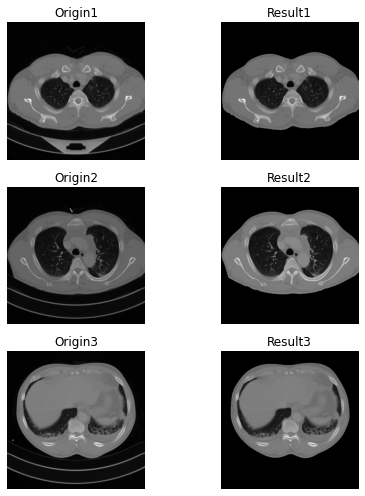

In [4]:
bound = BodyBoundary()

origin1 = sitk.GetArrayFromImage(sitk.ReadImage(path1)).squeeze()
origin2 = sitk.GetArrayFromImage(sitk.ReadImage(path2)).squeeze()
origin3 = sitk.GetArrayFromImage(sitk.ReadImage(path3)).squeeze()

img1 = bound(origin1)
img2 = bound(origin2)
img3 = bound(origin3)

fig, axes = plt.subplots(3, 2, figsize=(7, 7))

img_data = [origin1, origin2, origin3, img1, img2, img3]

for i in range(3):
    axes[i, 0].set_title(f'Origin{i+1}')
    axes[i, 0].axis('off')
    axes[i, 0].imshow(img_data[i], cmap='gray')
    
    axes[i, 1].set_title(f'Result{i+1}')
    axes[i, 1].axis('off')
    axes[i, 1].imshow(img_data[i+3], cmap='gray')

fig.tight_layout()
plt.show()